In [2]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [4]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class UNet(nn.Module):
    def __init__(self, in_channels = 3, out_classes=2, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(in_channels, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x
    

# Get UNet model
model = UNet(in_channels = 4, out_classes = 6)

In [5]:
!pip install rasterio

In [6]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import cv2
import os
import numpy as np
import rasterio
class Segmentation4bDataset(Dataset):
    def __init__(self, input_dirs, mask_dirs):
        self.input_dirs = input_dirs
        self.mask_dirs = mask_dirs
        image_list = []
        mask_list = []
        for input_dir in input_dirs:
            for file in os.listdir(input_dir):
                if not file.endswith(('.tif', '.tiff')):
                    continue
                image_list.append(os.path.join(input_dir, file))
            
        for mask_dir in mask_dirs:
            for file in os.listdir(mask_dir):
                mask_list.append(os.path.join(mask_dir, file))
            
        self.image_list = sorted(image_list)
        self.mask_list = sorted(mask_list)
        
        assert len(self.image_list) == len(self.mask_list), "The number of images and masks must be the same."

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        dataset = rasterio.open(self.image_list[idx])
        image = np.stack((dataset.read(1), dataset.read(2), dataset.read(3), dataset.read(4)), axis=-1)
        image = np.moveaxis(image, -1, 0)
        
        mask = cv2.imread(self.mask_list[idx], cv2.IMREAD_GRAYSCALE)
        
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask)

        return image, mask

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
data_dirs = ['/kaggle/input/crop-scene-400x400/crop_scene_4b/crop_scene_4b/chua_kham_son', 
             '/kaggle/input/crop-scene-400x400/crop_scene_4b/crop_scene_4b/sun_hoabinh_cuoiha_1',
            '/kaggle/input/crop-scene-400x400/crop_scene_4b/crop_scene_4b/sun_hoabinh_cuoiha_2', 
             '/kaggle/input/crop-scene-400x400/crop_scene_4b/crop_scene_4b/sun_hoabinh_sangolf',
            '/kaggle/input/crop-scene-400x400/crop_scene_4b/crop_scene_4b/van_don34', 
             '/kaggle/input/crop-scene-400x400/crop_scene_4b/crop_scene_4b/vinaconex']

mask_dirs = ['/kaggle/input/crop-mask-400x400/crop_mask_400_400/tree_grass_mask/chua_kham_son', 
            '/kaggle/input/crop-mask-400x400/crop_mask_400_400/tree_grass_mask/sun_hoabinh_cuoiha_1',
            '/kaggle/input/crop-mask-400x400/crop_mask_400_400/tree_grass_mask/sun_hoabinh_cuoiha_2', 
            '/kaggle/input/crop-mask-400x400/crop_mask_400_400/tree_grass_mask/sun_hoabinh_sangolf',
            '/kaggle/input/crop-mask-400x400/crop_mask_400_400/tree_grass_mask/van_don34', 
            '/kaggle/input/crop-mask-400x400/crop_mask_400_400/tree_grass_mask/vinaconex']

# dataset = Segmentation4bDataset(input_dirs=data_dirs, mask_dirs=mask_dirs)
dataset = Segmentation4bDataset(input_dirs=data_dirs, mask_dirs=mask_dirs)
batch_size = 8

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
import os

# Set the environment variable
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

num_epochs = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)
all_loss = []
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
N = len(train_loader.dataset)

torch.cuda.empty_cache()
print("running")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, masks in train_loader:  # Assuming `dataloader` is your data loader
        inputs, masks = inputs.to(device), masks.to(device)
        masks = masks.squeeze(1).long()

        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / N
    all_loss.append(epoch_loss)
    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}')
    
print("complete")

cuda
running
Epoch 0/299, Loss: 1.1348
Epoch 1/299, Loss: 0.8720
Epoch 2/299, Loss: 0.7538
Epoch 3/299, Loss: 0.6661
Epoch 4/299, Loss: 0.6261
Epoch 5/299, Loss: 0.5739
Epoch 6/299, Loss: 0.5519
Epoch 7/299, Loss: 0.4997
Epoch 8/299, Loss: 0.4909
Epoch 9/299, Loss: 0.4735
Epoch 10/299, Loss: 0.4646
Epoch 11/299, Loss: 0.4450
Epoch 12/299, Loss: 0.4352
Epoch 13/299, Loss: 0.4077
Epoch 14/299, Loss: 0.3988
Epoch 15/299, Loss: 0.3986
Epoch 16/299, Loss: 0.3986
Epoch 17/299, Loss: 0.3664
Epoch 18/299, Loss: 0.3740
Epoch 19/299, Loss: 0.3733
Epoch 20/299, Loss: 0.3647
Epoch 21/299, Loss: 0.3577
Epoch 22/299, Loss: 0.3630
Epoch 23/299, Loss: 0.3417
Epoch 24/299, Loss: 0.3440
Epoch 25/299, Loss: 0.3461
Epoch 26/299, Loss: 0.3393
Epoch 27/299, Loss: 0.3279
Epoch 28/299, Loss: 0.3300
Epoch 29/299, Loss: 0.3160
Epoch 30/299, Loss: 0.3089
Epoch 31/299, Loss: 0.3181
Epoch 32/299, Loss: 0.3167
Epoch 33/299, Loss: 0.3080
Epoch 34/299, Loss: 0.2984
Epoch 35/299, Loss: 0.3032
Epoch 36/299, Loss: 0.295

In [10]:
# #save model
model_path = '/kaggle/working/unet_trained_4band_6class_300epochs.pth'

# Save the state dictionary of the model
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to /kaggle/working/unet_trained_4band_6class_300epochs.pth


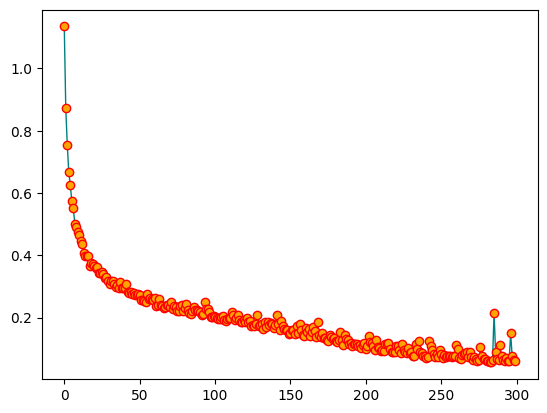

In [11]:
import matplotlib.pyplot as plt
x = [i for i in range(len(all_loss))]
y = all_loss
# plt.plot(x, y, color='orange')
plt.plot(x, y, color = 'teal', marker='o', markeredgecolor='red', markerfacecolor ='orange', linewidth=1, markersize=6)

In [8]:
#load model weights

# model_weights_path = '/kaggle/input/unet-4b/unet_trained_4band_6class_300epochs.pth'
# model.load_state_dict(torch.load(model_weights_path))
# # Set the model to evaluation mode
# model.eval()

UNet(
  (down_conv1): DownBlock(
    (double_conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down_sample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_conv2): DownBlock(
    (double_conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      

In [9]:
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

# data_dirs = ['/kaggle/input/crop-scene-400x400/crop_scene_4b/crop_scene_4b/kho_xang']
# mask_dirs = ['/kaggle/input/crop-mask-400x400/crop_mask_400_400/6_classes_mask/kho_xang']

data_dirs = ['/kaggle/input/cuoiha-test/data/crop_scene_4b']
mask_dirs = ['/kaggle/input/cuoiha-test/data/crop_mask_6class']
test_set = Segmentation4bDataset(input_dirs=data_dirs, mask_dirs=mask_dirs)

batch_size = 8

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [10]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, masks in data_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            masks = masks.squeeze(1).long()

            outputs = model(inputs)
            loss = criterion(outputs, masks)

            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(data_loader.dataset)
    return epoch_loss

criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
test_loss = evaluate_model(model, test_loader, criterion, device)
    
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 1.7877


In [11]:
#merge patches
import numpy as np
import cv2
import matplotlib.pyplot as plt

def merge(patches, mask_path, patch_size):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    img = np.zeros_like(mask)

    height = patch_size[0]
    width = patch_size[1]

    img_height = mask.shape[0]
    img_width = mask.shape[1]
    ct = 0
    for i in range(0, img_height, height):
        for j in range(0, img_width, width):
            img[i:min(i+height, img_height), j:min(j+width, img_width)] = patches[ct, : min(i+height, img_height)-i, : min(j+width, img_width)-j]
            # unique_vals(img[i:min(i+height, img_height), j:min(j+width, img_width)])
            ct += 1

    return img

In [12]:
from PIL import Image
import cv2
import os
import numpy as np

from PIL import Image
import torchvision.transforms as transforms
import torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predict(model, data_loader, device):
    all_predictions = []
    with torch.no_grad():
        for images in data_loader:
            images = images[0]  # Extract the images tensor from the tuple
            inputs = images.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
    return all_predictions

# Get predictions
predictions = predict(model, test_loader, device)


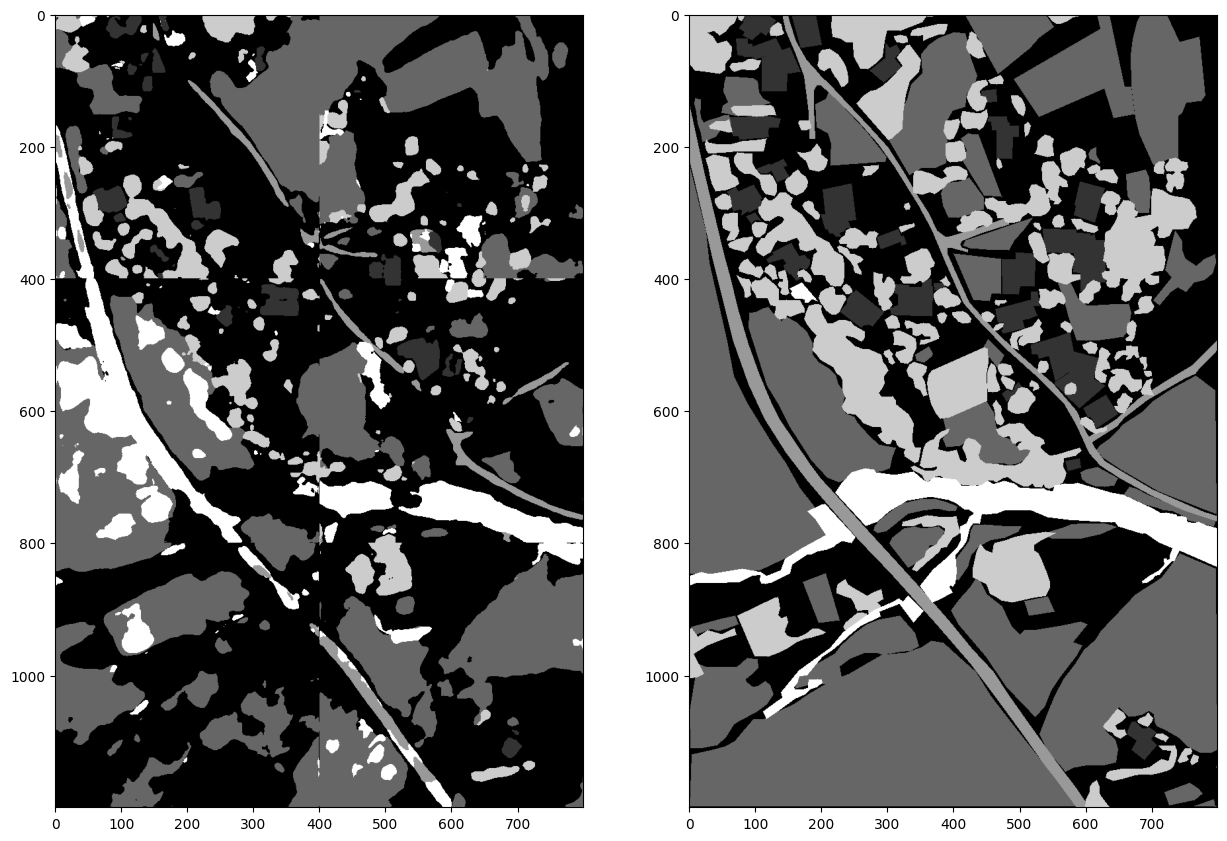

In [14]:
import matplotlib.pyplot as plt
import cv2
# mask_path = '/kaggle/input/masks-set/tree_grass/vinaconex_tree_grass.png'
# mask_path = '/kaggle/input/mask-files/6_classes_mask/kho_xang.png'
mask_path = '/kaggle/input/cuoiha-test/data/mask/6class_mask.png'

inferred_img = merge(pred, mask_path, (400,400))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(inferred_img, cmap='gray')

plt.subplot(1,2,2)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(mask, cmap='gray')

plt.show()

In [19]:
cv2.imwrite('/kaggle/working/inferred_img_4b_6class_300eps.jpeg', inferred_img)

True

In [15]:
# bgr_image = cv2.imread('/kaggle/input/map-files/scene_3b/kho_xang.tif')
bgr_image = cv2.imread('/kaggle/input/cuoiha-test/data/scene/sun_hoabinh_cuoiha_3b.tif')

rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB) 
color_seg = np.copy((rgb_image * 0.5).astype(np.uint8))

id2label = {
    0: 'background',
    1: 'building',
    2: 'grass',
    3: 'road',
    4: 'tree',
    5: 'water'
}

# label2color = {
#     'background': [0,0,0],
#     'tree': [37,110,10],
#     'grass': [240,19,19]
# }

id2color = {
    0: [0,0,0],
    1: [240,19,19],
    2: [141,253,113],
    3: [193,201,88],
    4: [6,132,27],
    5: [52,85,247]
}

for label, color in id2color.items():
    color_seg[inferred_img == label, :] = color

img = rgb_image * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)


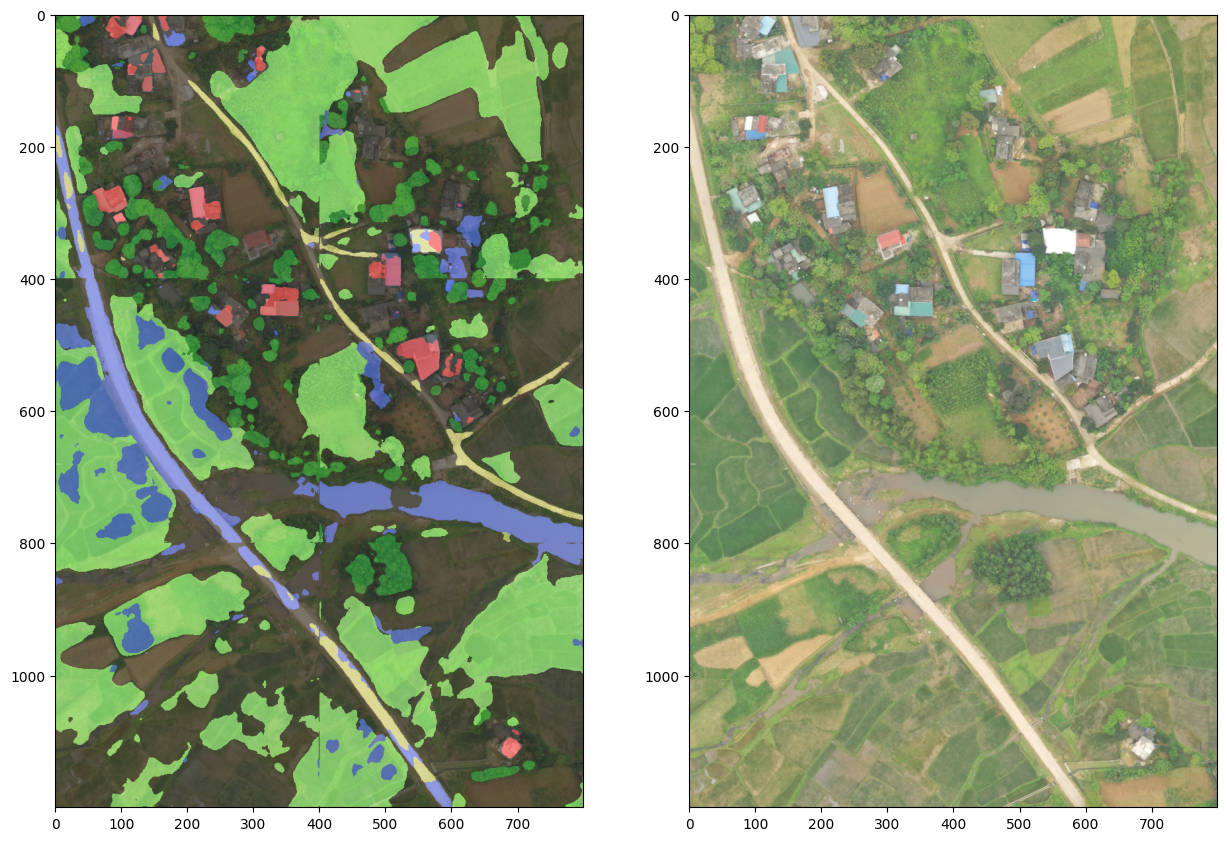

In [16]:
plt.figure(figsize=(15, 15))

plt.subplot(1,2,1)
plt.imshow(img)

plt.subplot(1,2,2)
plt.imshow(rgb_image)
# plt.imshow(img)
plt.show()

In [22]:
cv2.imwrite('/kaggle/working/mask_inferred_img_4b_300eps.jpeg', img)
# cv2.imwrite('/kaggle/working/inferred_img_4b_300eps.jpeg', inferred_img)

True

In [16]:
def calculate_iou(gt, pred, num_classes):
#     ious = []
#     for c in range(num_classes):
#         pred_class = (pred == c)
#         gt_class = (gt == c)
        
#         intersection = np.logical_and(pred_class, gt_class).sum()
#         union = np.logical_or(pred_class, gt_class).sum()
        
#         if union == 0:
#             iou = float('nan')  # Avoid division by zero, assign NaN
#         else:
#             iou = intersection / union
#         ious.append(iou)
    height, width = gt.shape
    ct = 0
    N = height * width
#     N = 0
    
    for i in range(height):
        for j in range(width):
#             if gt[i,j] != 0:
#                 N += 1
            if gt[i, j] == pred[i, j]:
                ct += 1
    
    return ct / N

In [17]:
# mask_path = '/kaggle/input/mask-files/6_classes_mask/kho_xang.png'
mask_path = '/kaggle/input/testset/test_dataset/sun_hoabinh_sangolf/sun_hoabinh_sangolf_3class_mask.png'
ground_truth = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
calculate_iou(ground_truth, inferred_img, 3)


0.8873035714285714

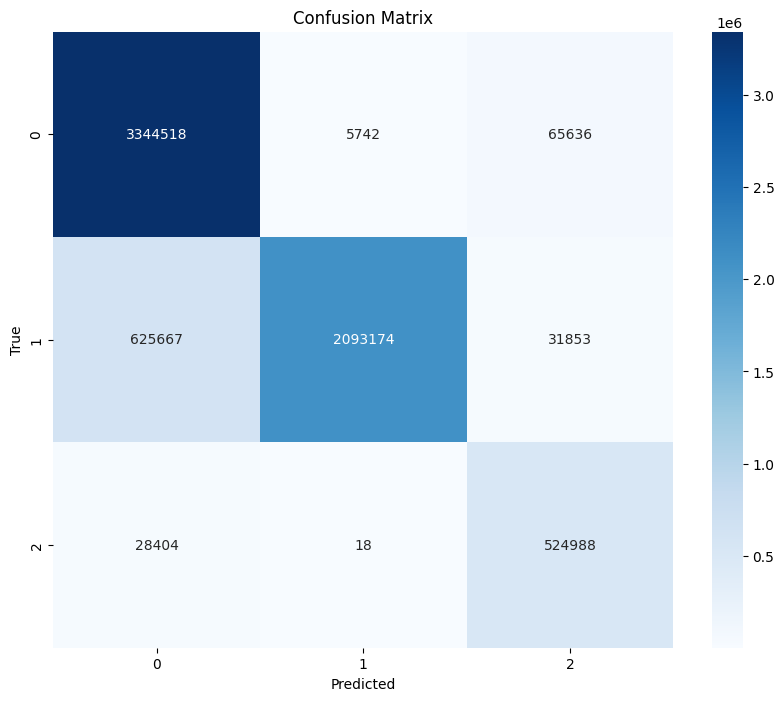

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


label = ground_truth.ravel()
pred = inferred_img.ravel()

cm = confusion_matrix(label, pred, labels=[0, 1, 2])


# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
import torch
import torchmetrics

# Example labels and predictions for 3 classes (0, 1, 2)
labels = torch.tensor(label)
predictions = torch.tensor(pred)

# Define the task
task = 'multiclass'

# Initialize metrics
precision = torchmetrics.Precision(task=task, average='macro', num_classes=3)
recall = torchmetrics.Recall(task=task, average='macro', num_classes=3)
f1_score = torchmetrics.F1Score(task=task, average='macro', num_classes=3)
accuracy = torchmetrics.Accuracy(task=task, num_classes=3)

# Compute metrics
precision_value = precision(predictions, labels)
recall_value = recall(predictions, labels)
f1_value = f1_score(predictions, labels)
accuracy_value = accuracy(predictions, labels)

# Print results
print(f'Precision: {precision_value:.4f}')
print(f'Recall: {recall_value:.4f}')
print(f'F1 Score: {f1_value:.4f}')
print(f'Accuracy: {accuracy_value:.4f}')


6 classes segmentaion
